# Extract GPS data from dashcam footage
gps_bend_finding_with_gaussian_clustering_with_catrisian_positions

In [152]:
ids = [43]
# 10

min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"


In [153]:
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [154]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_epoch(time_stamp:str):
    """Convert a time stamp to epoch time

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The epoch time
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    milliseconds = int(time_stamp[7:])

    return (hours*60*60 + minutes*60 + seconds)*1000 + milliseconds

# Lat and Long to X and Y

In [155]:
def lat_lon_to_x_y(lat:float, lon:float, height:float = 0):
    """Convert latitude, longitude and height to x, y and z

    Args:
        lat (float): latitude
        lon (float): longitude
        height (float): height above sea level
    """
    a = 6378137.0 # equatorial radius
    f = 0.003352810681183637418 # flattening

    e2 = f*(2-f) # first eccentricity squared

    Rn = a / np.sqrt(1 - e2*np.sin(lat)**2) # radius of curvature in the prime vertical

    lat = np.radians(lat)
    lon = np.radians(lon)

    # calculate x, y, z
    x = (Rn + height) * np.cos(lat) * np.cos(lon)
    y = (Rn + height) * np.cos(lat) * np.sin(lon)
    z = (Rn*(1-e2) + height) * np.sin(lat)

    return x, y, z

In [156]:
file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 043 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/043/bends


In [157]:
!firefox {file_path} # display the video

Gtk-Message: 23:31:51.434: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[101217, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox:101217): Gtk-WARNING **: 23:31:51.509: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 23:31:51.509: Failed to load module "canberra-gtk-module"
[101217, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same proc

# Read file contents

In [158]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

In [159]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} strings, of which {frame_count} frames are available')
data[:10]

Found 4022 strings, of which 5400 frames are available


['$GPRMC,094119.300,A,5309.10547,N,00224.68437,W,22.518,144.09,241124,,,A*63',
 '$GPGGA,094119.300,5309.10547,N,00224.68437,W,1,13,0.75,46.4,M,49.7,M,,*59',
 '$GPRMC,094119.400,A,5309.10496,N,00224.68378,W,22.666,144.75,241124,,,A*64',
 '$GPGGA,094119.400,5309.10496,N,00224.68378,W,1,13,0.75,46.5,M,49.7,M,,*5E',
 '$GPRMC,094119.500,A,5309.10444,N,00224.68318,W,22.665,144.38,241124,,,A*66',
 '$GPGGA,094119.500,5309.10444,N,00224.68318,W,1,13,0.75,46.6,M,49.7,M,,*55',
 '$GPRMC,094119.600,A,5309.10393,N,00224.68259,W,22.558,143.95,241124,,,A*61',
 '$GPGGA,094119.600,5309.10393,N,00224.68259,W,1,13,0.75,46.7,M,49.7,M,,*5E',
 '$GPRMC,094119.700,A,5309.10342,N,00224.68198,W,22.310,143.32,241124,,,A*65',
 '$GPGGA,094119.700,5309.10342,N,00224.68198,W,1,12,0.86,46.7,M,49.7,M,,*50']

In [160]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_GPRMC = input_sequence[0].split(',')
    if len(parts_GPRMC) < 10 or parts_GPRMC[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<satellites>,<HDOP>,<height>,<height unit>,<geoid separation>,<geoid separation unit>,<age of differential data>,<station ID>,<checksum>
    parts_GPGGA = input_sequence[1].split(',')
    if len(parts_GPGGA) < 10 or parts_GPGGA[0] != '$GPGGA':
        # print(f'Invalid GPGGA string: {input_sequence}')
        return None

    
    # Extract latitude and longitude with direction
    time = parts_GPRMC[1]
    valid = parts_GPRMC[2]  # A - data valid, V - data invalid
    latitude = parts_GPRMC[3]
    lat_direction = parts_GPRMC[4]
    longitude = parts_GPRMC[5]
    lon_direction = parts_GPRMC[6]
    height = parts_GPGGA[9]  # Height above sea level
    speed = parts_GPRMC[7]  # Speed in knots

    speed = knots_to_mph(float(speed))  # Convert speed to mph
    
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": latitude + ' ' + lat_direction,
        "longitude": longitude + ' ' + lon_direction,
        "height": height,
        "speed": speed
    }

In [161]:
positions = []
for i in range(0, len(data), 2):
    lat_lon = parse_gprmc(data[i:i+2])
    if lat_lon:
        positions.append(lat_lon)

print(f"Found {len(positions)} positions")
print("valid positions:", len([p for p in positions if p['valid']]))
print("invalid positions:", len([p for p in positions if not p['valid']]))

STARTING_TIME = time_stamp_to_epoch(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_epoch(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")



positions[:2]


Found 2011 positions
valid positions: 2011
invalid positions: 0
Starting time: 34879300
Ending time: 35059300
Unique positions: 1820


[{'time': '094222.100',
  'valid': True,
  'latitude': '5308.79166 N',
  'longitude': '00224.56681 W',
  'height': '48.1',
  'speed': 24.138761279999997},
 {'time': '094240.700',
  'valid': True,
  'latitude': '5308.71272 N',
  'longitude': '00224.44791 W',
  'height': '43.8',
  'speed': 19.596632619999998}]

### Convert Lat Lon to X, Y

In [162]:
for position in positions:
    lat, lon = position['latitude'], position['longitude']
    lat = float(lat.split()[0])
    lon = float(lon.split()[0])
    h = float(position['height'])
    position['x'], position['y'], position['z'] = lat_lon_to_x_y(np.radians(lat), np.radians(lon), h)

positions[:2]

[{'time': '094222.100',
  'valid': True,
  'latitude': '5308.79166 N',
  'longitude': '00224.56681 W',
  'height': '48.1',
  'speed': 24.138761279999997,
  'x': np.float64(-295849.3382355554),
  'y': np.float64(-20269.78194093797),
  'z': np.float64(6349962.687321905)},
 {'time': '094240.700',
  'valid': True,
  'latitude': '5308.71272 N',
  'longitude': '00224.44791 W',
  'height': '43.8',
  'speed': 19.596632619999998,
  'x': np.float64(-295696.44935516204),
  'y': np.float64(-20248.546852781703),
  'z': np.float64(6349964.189501359)}]

## Remove invalid records and records under 15 mph

In [163]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than 15 mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < 15:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [164]:
positions = filter_invalid_and_low_mph_records(positions)

print(f"{len(positions)} positions after filtering")
positions[:2]

1612 positions after filtering


[{'time': '094222.100',
  'valid': True,
  'latitude': '5308.79166 N',
  'longitude': '00224.56681 W',
  'height': '48.1',
  'speed': 24.138761279999997,
  'x': np.float64(-295849.3382355554),
  'y': np.float64(-20269.78194093797),
  'z': np.float64(6349962.687321905)},
 {'time': '094240.700',
  'valid': True,
  'latitude': '5308.71272 N',
  'longitude': '00224.44791 W',
  'height': '43.8',
  'speed': 19.596632619999998,
  'x': np.float64(-295696.44935516204),
  'y': np.float64(-20248.546852781703),
  'z': np.float64(6349964.189501359)}]

## Plot on graph

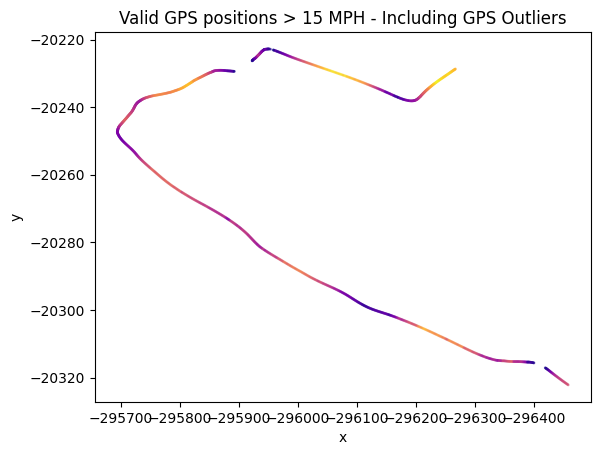

In [165]:
# longitudes = [float(pos['longitude'].split()[0]) for pos in positions]
# latitudes = [float(pos['latitude'].split()[0]) for pos in positions]

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma


plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('x')
plt.ylabel('y')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH - Including GPS Outliers')
# show heat map of point concentration
plt.show()

# remove outliers

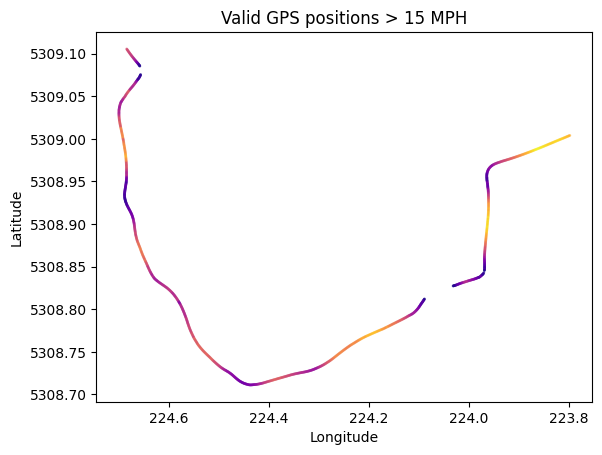

Median Longitude: 224.43157000000002
Median Latitude: 5308.849155


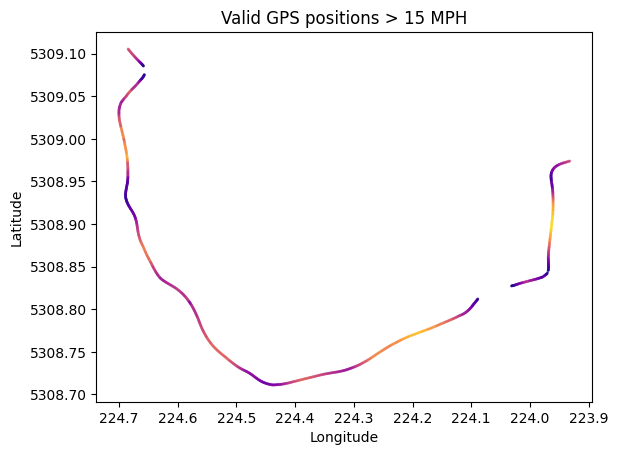

In [166]:
x = [float(pos['longitude'].split()[0]) for pos in positions]
y = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH')
# show heat map of point concentration
plt.show()

median_longitude = np.median(x)
median_latitude = np.median(y)

print(f'Median Longitude: {median_longitude}')
print(f'Median Latitude: {median_latitude}')

# filter out the points that are not within GPGGA (
positions = [pos for pos in positions if abs(float(pos['longitude'].split()[0]) - median_longitude) < 0.5 and abs(float(pos['latitude'].split()[0]) - median_latitude) < 0.5]

x = [float(pos['longitude'].split()[0]) for pos in positions]
y = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]


plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH')
# show heat map of point concentration
plt.show()

# Find bends

Found 1474 angles
[-13.66008672 -10.90725352  -7.80194122  -5.69050403  -1.99251996]


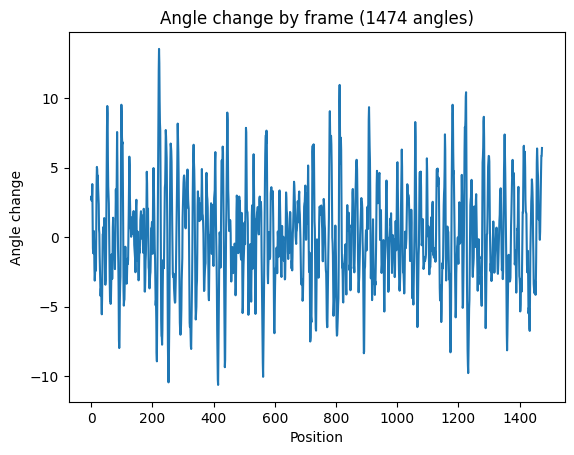

Found 160 bends
[ 7.90926925  9.42082036  8.87981702  7.55070629 -7.403376   -7.97577555
 -7.38417668  6.38639953  9.51137384  8.79619555]
Found 17 bends after clustering


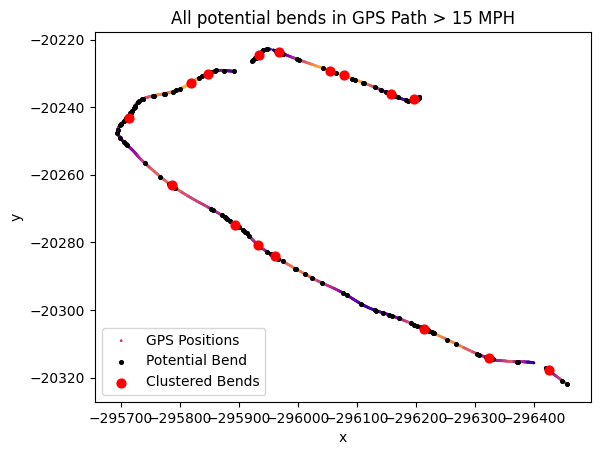

In [167]:
from sklearn.cluster import DBSCAN

x_pos = [pos['x'] for pos in positions]
y_pos = [pos['y'] for pos in positions]

diff_x = np.diff(x_pos)
diff_y = np.diff(y_pos)
vectors = np.vstack((diff_x, diff_y)).T

angles = np.arctan2(diff_x, diff_y)

angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles

angles = np.degrees(angles)

# smooth angles with gaussian filter
angles = np.convolve(angles, np.ones(3) / 3, mode='valid')
gaussian_kernel = np.exp(-np.linspace(-1, 1, 12)**2)

# zero first half of the kernel
zero = np.zeros_like(gaussian_kernel)
gaussian_kernel = np.concatenate([zero, gaussian_kernel])
gaussian_kernel /= gaussian_kernel.sum()
angles = np.convolve(angles, gaussian_kernel, mode='valid')

print(f"Found {len(angles)} angles")
print(angles[:5])
angles_derivative = np.gradient(angles)

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.show()

# angle change threshold
lower_threshold = 6  # degrees
# angle_diff = np.abs(np.diff(angles))
bends = np.where(np.abs(angles_derivative) > lower_threshold)[0]

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:10])

# cluster bends
bends_positions = np.array(list(zip(x_pos, y_pos)))[bends]

temp_store_bends = bends_positions.copy()


# bends = cluster.vq.kmeans(bends_positions, )[0]
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=10, min_samples=3, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    bends = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    bends = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(bends)} bends after clustering")

# ignore last bend due to noisy data
bends = bends[:-1]

plt.scatter(
    x_pos,
    y_pos,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(bends) > 0:
    plt.scatter(
        bends[:,0],
        bends[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])
    
plt.title("All potential bends in GPS Path > 15 MPH")
plt.ylabel("y")
plt.xlabel("x")
plt.gca().invert_xaxis()
# plt.legend(["GPS Positions", "Potential Bend", "Clustered Bends"])
plt.legend()

plt.savefig(os.path.join(output_folder, "bends.png"))
plt.show()

In [168]:
bends

array([[-295785.80586395,  -20263.17262443],
       [-296214.29496716,  -20305.64112683],
       [-295713.88664593,  -20243.19090635],
       [-296197.12039706,  -20237.68238469],
       [-295893.67357507,  -20274.77516434],
       [-295931.65773816,  -20280.71528699],
       [-295960.40753226,  -20284.13557386],
       [-296157.65528712,  -20236.1802785 ],
       [-295933.11827108,  -20224.66576073],
       [-296324.47688269,  -20314.31507354],
       [-295818.66605243,  -20232.7184314 ],
       [-296053.87688554,  -20229.15937148],
       [-295848.09407031,  -20230.05395023],
       [-296425.24229138,  -20317.86232488],
       [-295967.96728958,  -20223.71675656],
       [-296077.23334878,  -20230.57323542]])

In [169]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


In [170]:
def time_stamp_to_frame_number(time_stamp):
    diff = time_stamp_to_epoch(time_stamp) - STARTING_TIME
    total_time = END_TIME - STARTING_TIME
    if total_time <= 0:
        return 0
    
    return int((diff / total_time) * total_frames)

def get_closest_position_based_on_lat_lon(lat, lon):
    min_distance = float('inf')
    closest_position = None
    for position in positions:
        p_lat = float(position['y'])
        p_lon = float(position['x'])
        distance = (p_lat - lat)**2 + (p_lon - lon)**2
        if distance < min_distance:
            min_distance = distance
            closest_position = position
    return closest_position


def get_frame_number_based_on_bend_long_lat(bends):
    frame_numbers = []
    for bend in bends:
        closest_position = get_closest_position_based_on_lat_lon(bend[1], bend[0])
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

frame_numbers = get_frame_number_based_on_bend_long_lat(bends)

# frame_numbers = [int(frame_number*(frame_rate/10)) for frame_number in frame_numbers]

frame_numbers

[2058,
 756,
 2705,
 4992,
 1745,
 1584,
 1490,
 4848,
 4191,
 498,
 3273,
 4614,
 3420,
 117,
 4401,
 4656]

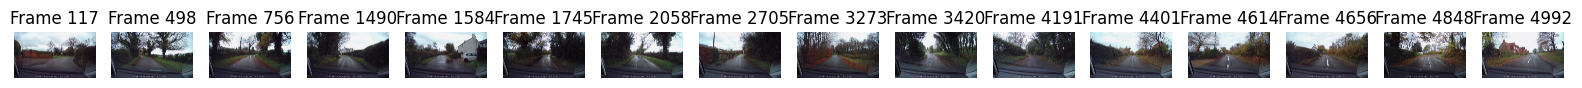

Total frames: 5400


In [171]:
frames = []

frame_numbers = sorted(frame_numbers)

for frame_number in frame_numbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        print(f"Warning: Could not read frame {frame_number}")
 
cap.release()

if frames:
    fig, axes = plt.subplots(1, len(frames), figsize=(20, 10))
    if len(frames) == 1:
        axes.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
        axes.axis('off')
        axes.set_title(f"Frame {frame_numbers[0]}")
    else:
        for i, frame in enumerate(frames):
            axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f"Frame {frame_numbers[i]}")
    plt.show()
else:
    print("No frames to display")

print(f"Total frames: {total_frames}")

In [172]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)
